# Import module, packages

In [124]:
!pip install iPython_SQL

In [461]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.edge.service import Service
import pandas as pd
import os
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import csv, sqlite3

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



In [467]:
def scrapping():
    # Khởi tạo trình duyệt Edge với Selenium
    service = Service('msedgedriver.exe')
    driver = webdriver.Edge(service=service)
    
    # Cào dữ liệu từ trang 1 tới trang 2000, mỗi trang trung bình 20 bất động sản
    for page in range(1,2001):
        try:
            # Initial Fields
            price_list = list()
            location_list = list()
            area_list = list()
            priceByArea_list = list()
            bedroom_list = list()
            bathroom_list = list()
            
            # Mở trang web
            url = f'https://batdongsan.com.vn/ban-nha-dat/5pn/p{page}?rs=4,3,2,1'
            driver.get(url)
            
            # Đợi một lúc cho trang tải hoàn toàn
            time.sleep(4)
            
            # Button Processed - Xử lý pop-up đánh giá trải nghiệm người dùng
            try:
                close_button = driver.find_element(By.CLASS_NAME, 'close') 
                print("Close button found!")
                # Thực hiện thao tác click
                close_button.click()
                print("Close button clicked!")
                # Kiểm tra pop-up đã tắt chưa 
                time.sleep(1)  # Wait for the closing animation
                modal = driver.find_element(By.ID, 'dialogPopup')
                if not modal.is_displayed():
                    print("Modal closed successfully!")
                else:
                    print("Modal is still visible.")
            except :
                print("Close button not found!")
            
            # Chờ trang load sau khi tắt pop-up
            time.sleep(2)
    
            # Thực hiện thao tác cuộn để trang web load hết dữ liệu
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(1) 
        
    
            # Thu thập các dữ liệu gồm: vị trí, giá, giá trên mét vuông, số phòng ngủ, số toilet
            
            # Trường vị trí
            locations = driver.find_elements(By.CLASS_NAME, 're__card-location')
            for location in locations:
                spans = location.find_elements(By.TAG_NAME, 'span')
                if location.find_elements(By.CLASS_NAME, 're__icon-location--sm') and spans:
                    location_list.append(spans[0].text)
                elif len(spans) > 1:
                    location_list.append(spans[1].text) 
                else:
                    location_list.append('Unknown')
        
            # Trường còn lại
            card_configs = driver.find_elements(By.CSS_SELECTOR, '.re__card-config.js__card-config')
            for card in card_configs:
                result = card.text.split('\n')
                # Cào giá nhà
                price_list.append(result[0])
                
                # Cào diện tích
                area_list.append(result[2])
                
                # Cào giá trên đơn vị diện tích
                priceByArea_list.append(result[4] if len(result) > 4 else 'Null')
                
                # Cào số phòng ngủ, toilet
                bedroom_list.append(result[6] if len(result) > 6 else 'Null')
                bathroom_list.append(result[8] if len(result) > 8 else 'Null')
            
            # Xử lý outlier
            if 'Vay mua nhà' in price_list:
                price_list.remove('Vay mua nhà')
        
            # Kiểm tra số lượng phần tử đã cào được
            print(f'Price: {len(price_list)}')
            print(f'Location: {len(location_list)}')
            print(f'Area: {len(area_list)}')
            print(f'Price/m2: {len(priceByArea_list)}')
            print(f'BedRoom: {len(bedroom_list)}')
            print(f'Toilet: {len(bathroom_list)}')
            
            
            # Lưu data
            data = {'Page': [page for i in range(len(price_list))],'Price': price_list, 'Location': location_list, 'Area': area_list, 'Price/m2': priceByArea_list, 
                   'BedRoom':bedroom_list, 'Toilet': bathroom_list}
            df = pd.DataFrame(data)
            if os.path.exists('HouseData.csv'):
                df.to_csv('HouseData.csv', mode='a', header=False, index=False)
            else:
                df.to_csv('HouseData.csv', mode='w', header=True, index=False)
            print(f'Page {page} is done.')
        except:
            print(f'Error with page{page}')
    # Done vòng lặp
    
    # Đóng drive trình duyệt
    driver.quit()
    
    # KẾT THÚC

### Data Cleaning

In [469]:
df = pd.read_csv('HouseData.csv')
df

,Page,Price,Location,Area,Price/m2,BedRoom,Toilet
0,1,8 tỷ,"Văn Giang, Hưng Yên",72 m²,"111,11 tr/m²",5,4
1,1,"7,4 tỷ","Văn Giang, Hưng Yên",63 m²,"117,46 tr/m²",8,4
2,1,"11,9 tỷ","Văn Giang, Hưng Yên",112 m²,"106,25 tr/m²",6,6
3,1,Giá thỏa thuận,"Đông Anh, Hà Nội",75 m²,8,7,Null
4,1,60 tỷ,"Quận 2, Hồ Chí Minh",300 m²,200 tr/m²,5,5
...,...,...,...,...,...,...,...
39899,2000,51 tỷ,"Hạ Long, Quảng Ninh",360 m²,"141,67 tr/m²",7,5
39900,2000,Giá thỏa thuận,"Quận 3, Hồ Chí Minh",124 m²,3,2,Null
39901,2000,"25,5 tỷ","Đống Đa, Hà Nội",86 m²,"296,51 tr/m²",4,7
39902,2000,"10,12 tỷ","Quận 12, Hồ Chí Minh",115 m²,88 tr/m²,2,2


In [470]:
# 1.Xử lý null

In [471]:
df['Price'] = df['Price'].apply(lambda x: x if 'Giá thỏa thuận' not in x else np.nan)
df['Price/m2'] = df['Price/m2'].apply(lambda x: x if ('Null' not in x) and ('tr/m²' in x) else np.nan)
df['BedRoom'] = df['BedRoom'].apply(lambda x: x if 'Null' not in x else np.nan)
df['Toilet'] = df['Toilet'].apply(lambda x: x if 'Null' not in x else np.nan)

In [472]:
df.isnull().sum()

Page           0
Price       4030
Location       0
Area           0
Price/m2    4111
BedRoom      247
Toilet      7210
dtype: int64

In [473]:
df.dropna(inplace=True, axis=0)
df.reset_index(inplace=True, drop=True)
df.isnull().sum()

Page        0
Price       0
Location    0
Area        0
Price/m2    0
BedRoom     0
Toilet      0
dtype: int64

In [474]:
# 2.Figure lại định dạng của từng cột

In [475]:
def convert_to_float(x):
    x = x.replace('.', '')
    x = x.replace(',', '.')
    return float(x)

def convert_unit(x):
    num = x.split(' ')[0].strip()
    num = convert_to_float(num)
    if 'tỷ' in x:
        return num * (10**9)
    elif 'triệu' in x:
        return num * (10**6)
    elif 'nghìn' in x:
        return num * (10**3)
    
# 2.1 Xử lý cột Area
df.Area = df.Area.apply(lambda x: x.split(' ')[0].strip())
df.Area = df.Area.apply(convert_to_float)

# 2.2 Xử lý cột Price/m2
df['Price/m2'] = df['Price/m2'].apply(lambda x: x.split(' ')[0].strip())
df['Price/m2'] = df['Price/m2'].apply(convert_to_float)
df['Price/m2'] = df['Price/m2'].apply(lambda x: x * 1000000) # Chuyển về đơn vị triệu

# 2.3 Xử lý cột Price
df.Price = df.Price.apply(convert_unit)

# 2.4 Xử lý cột BedRoom
df.BedRoom = df.BedRoom.apply(convert_to_float)

# 2.5 Xử lýcột Toilet
df.Toilet = df.Toilet.apply(convert_to_float)

# 2.5 Xóa cột page
df.drop(columns=['Page'], inplace = True)

In [476]:
df['Province'] = df['Location'].apply(lambda x: x.split(',')[1].strip())
df.Province.value_counts()

Province
Hồ Chí Minh        14618
Hà Nội             12253
Đà Nẵng             1162
Bình Dương           956
Đồng Nai             608
Hải Phòng            602
Khánh Hòa            545
Hưng Yên             345
Bà Rịa Vũng Tàu      222
Long An              220
Lâm Đồng             159
Quảng Ninh           120
Bắc Ninh             117
Bình Thuận            91
Kiên Giang            84
Cần Thơ               64
Tây Ninh              47
Thanh Hóa             41
Đắk Lắk               38
Nghệ An               37
Quảng Nam             36
Phú Thọ               26
Bình Định             25
Hà Nam                25
Vĩnh Phúc             20
Tiền Giang            15
Thừa Thiên Huế        14
Lào Cai               11
Bình Phước            10
Phú Yên               10
Hòa Bình               9
Thái Bình              9
Quảng Bình             8
Đắk Nông               7
Vĩnh Long              6
Bắc Giang              6
Hà Tĩnh                6
Ninh Thuận             5
An Giang               5
Bến Tre         

#### Data Preparation

In [478]:
# Thêm thông tin cho datset

df['Province'] = df['Location'].apply(lambda x: x.split(',')[1].strip())
df['AreaSegment'] = pd.cut(x=df['Area'], bins=[0, 30, 50, 100, 150, 250, 350, 500, 999999], 
                           labels=["Dưới 30m²", "30m² - 50m²", "50m² - 100m²", "100m² - 150m²", "150m² - 250m²", "250m² - 350m²", "350m² - 500m²", "Trên 500m²"])
df['PriceSegment'] = pd.cut(x=df['Price'], bins=[0, 500*(10**6), 1*(10**9), 5*(10**9), 10*(10**9), 20*(10**9), 40*(10**9), 60*(10**9), 100*(10**9), 1000*(10**9) ], 
                           labels=["Dưới 500 triệu", "500 triệu - 1 tỷ", "1 tỷ - 5 tỷ", "5 tỷ - 10 tỷ", "10 tỷ - 20 tỷ", "20 tỷ - 40 tỷ", "40 tỷ - 60 tỷ", "60 tỷ - 100 tỷ", "100 tỷ - 1000 tỷ"])

# Tập trung phân tích data tại khu vực đang phát triển mạnh
new_development_zone = ['Long An', 'Bình Dương', 'Đồng Nai']

df_newzone = df.loc[df.Province.isin(new_development_zone)]
df_newzone.reset_index(drop=True, inplace=True)

#### Data After Step Preparing

In [480]:
df_newzone = df_newzone[['Province', 'Location', 'Area', 'AreaSegment', 'Price/m2',	'BedRoom', 'Toilet', 'Price', 'PriceSegment']]
df_newzone

,Province,Location,Area,AreaSegment,Price/m2,BedRoom,Toilet,Price,PriceSegment
0,Bình Dương,"Bến Cát, Bình Dương",100.0,50m² - 100m²,21000000.0,1.0,1.0,2.100000e+09,1 tỷ - 5 tỷ
1,Bình Dương,"Thuận An, Bình Dương",62.0,50m² - 100m²,59680000.0,4.0,4.0,3.700000e+09,1 tỷ - 5 tỷ
2,Long An,"Bến Lức, Long An",90.0,50m² - 100m²,35560000.0,3.0,2.0,3.200000e+09,1 tỷ - 5 tỷ
3,Long An,"Bến Lức, Long An",80.0,50m² - 100m²,37380000.0,3.0,4.0,2.990000e+09,1 tỷ - 5 tỷ
4,Đồng Nai,"Nhơn Trạch, Đồng Nai",320.0,250m² - 350m²,50000000.0,3.0,3.0,1.600000e+10,10 tỷ - 20 tỷ
...,...,...,...,...,...,...,...,...,...
1779,Long An,"Đức Hòa, Long An",90.0,50m² - 100m²,27220000.0,3.0,4.0,2.450000e+09,1 tỷ - 5 tỷ
1780,Bình Dương,"Dĩ An, Bình Dương",115.8,100m² - 150m²,39720000.0,4.0,2.0,4.600000e+09,1 tỷ - 5 tỷ
1781,Bình Dương,"Thuận An, Bình Dương",97.5,50m² - 100m²,35900000.0,3.0,3.0,3.500000e+09,1 tỷ - 5 tỷ
1782,Bình Dương,"Thuận An, Bình Dương",67.5,50m² - 100m²,29630000.0,4.0,4.0,2.000000e+09,1 tỷ - 5 tỷ


In [482]:
con = sqlite3.connect("HouseData.db")
cur = con.cursor()

In [483]:
#Kích Hoạt SQL Magic
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [484]:
# Cho phép SQL Magic kết nối với CSDL
%sql sqlite:///HouseData.db

In [485]:
# Import DataFrame vào cơ sở dữ liệu
df_newzone.to_sql('KhuVucPhatTrienMoi', con, if_exists='replace', index=False)

1784

In [486]:
%%sql
SELECT *
FROM KhuVucPhatTrienMoi
WHERE Price >= 2500000000 and Area < 50;


 * sqlite:///HouseData.db
   sqlite:///SuperNha.db
Done.


Province,Location,Area,AreaSegment,Price/m2,BedRoom,Toilet,Price,PriceSegment
Đồng Nai,"Biên Hòa, Đồng Nai",46.5,30m² - 50m²,83870000.0,3.0,4.0,3900000000.0,1 tỷ - 5 tỷ
Đồng Nai,"Biên Hòa, Đồng Nai",47.0,30m² - 50m²,82980000.0,3.0,3.0,3900000000.0,1 tỷ - 5 tỷ
Đồng Nai,"Biên Hòa, Đồng Nai",47.5,30m² - 50m²,52630000.0,2.0,2.0,2500000000.0,1 tỷ - 5 tỷ
Đồng Nai,"Biên Hòa, Đồng Nai",46.5,30m² - 50m²,83870000.0,3.0,4.0,3900000000.0,1 tỷ - 5 tỷ
Đồng Nai,"Biên Hòa, Đồng Nai",47.5,30m² - 50m²,52630000.0,2.0,2.0,2500000000.0,1 tỷ - 5 tỷ
Bình Dương,"Dĩ An, Bình Dương",46.0,30m² - 50m²,59780000.0,3.0,3.0,2750000000.0,1 tỷ - 5 tỷ
Long An,"Đức Hòa, Long An",48.0,30m² - 50m²,53960000.0,5.0,3.0,2590000000.0,1 tỷ - 5 tỷ
Bình Dương,"Dĩ An, Bình Dương",42.0,30m² - 50m²,61670000.0,2.0,2.0,2590000000.0,1 tỷ - 5 tỷ
Bình Dương,"Dĩ An, Bình Dương",48.7,30m² - 50m²,55440000.0,2.0,2.0,2700000000.0,1 tỷ - 5 tỷ
Bình Dương,"Dĩ An, Bình Dương",43.0,30m² - 50m²,60460000.0,2.0,2.0,2600000000.0,1 tỷ - 5 tỷ


In [487]:
con.close()

### Phân tích giá nhà tại các tỉnh có nền kinh tế công nghiệp đang phát triển mạnh

1.	Giá trị trung bình (mean).
2.	Trung vị (median).
3.	Độ lệch chuẩn (std).
4.	Giá trị nhỏ nhất (min).
5.	Giá trị lớn nhất (max).
6.	Phân vị thứ 25% (25% quantile).
7.	Phân vị thứ 75% (75% quantile).

In [491]:
stats = df_newzone.describe()
print("Thống kê mô tả tổng quát cho bất động sản:")
stats

Thống kê mô tả tổng quát cho bất động sản:


,Area,Price/m2,BedRoom,Toilet,Price
count,1784.000000,1.784000e+03,1784.000000,1784.000000,1.784000e+03
mean,135.488599,4.426158e+07,3.573991,3.216368,5.911011e+09
std,124.484026,2.487941e+07,2.589750,2.506803,7.433974e+09
min,11.000000,2.080000e+06,1.000000,1.000000,3.800000e+08
25%,73.150000,2.850000e+07,3.000000,2.000000,2.590000e+09
50%,100.000000,3.984000e+07,3.000000,3.000000,3.600000e+09
75%,144.500000,5.393000e+07,4.000000,4.000000,6.500000e+09
max,1431.900000,2.800000e+08,46.000000,46.000000,1.500000e+11


In [492]:
# 8. Độ biến thiên giá theo khu vực
price_variance_by_location = df_newzone.groupby('Location')['Price'].var()
price_variance_by_location

Location
Biên Hòa, Đồng Nai         2.947257e+19
Bàu Bàng, Bình Dương       3.625382e+17
Bến Cát, Bình Dương        3.905107e+18
Bến Lức, Long An           1.081198e+20
Cần Giuộc, Long An         4.107556e+18
Cần Đước, Long An          1.026543e+18
Dĩ An, Bình Dương          2.066786e+19
Long Khánh, Đồng Nai       2.126027e+18
Long Thành, Đồng Nai       1.015783e+19
Nhơn Trạch, Đồng Nai       1.528883e+20
Phú Giáo, Bình Dương       8.912800e+17
Thuận An, Bình Dương       5.891680e+18
Thủ Dầu Một, Bình Dương    1.512937e+20
Thủ Thừa, Long An          4.555583e+19
Trảng Bom, Đồng Nai        4.637792e+18
Tân An, Long An            6.934415e+18
Tân Uyên, Bình Dương       3.684244e+18
Vĩnh Cửu, Đồng Nai         7.546046e+17
Xuân Lộc, Đồng Nai                  NaN
Định Quán, Đồng Nai        0.000000e+00
Đức Hòa, Long An           1.066247e+18
Name: Price, dtype: float64

In [493]:
# 9. Số lượng bất động sản theo từng khu vực
count_by_province = df_newzone['Province'].value_counts()
count_by_province

Province
Bình Dương    956
Đồng Nai      608
Long An       220
Name: count, dtype: int64

In [494]:
# 10. Hệ số biến thiên giá (coefficient of variation)
cv = (df_newzone['Price'].std()) / (df_newzone['Price'].mean())
cv

1.2576485340485242

Hệ số biến thiên 125%: mức độ phân tán của dữ liệu giá nhà lớn

In [496]:
# 11. Độ lệch trung bình tuyệt đối (mean absolute deviation)
price_data = df_newzone['Price']
mean_price = price_data.mean()
mad = (price_data - mean_price).abs().mean()

print("Mean Absolute Deviation (MAD):", mad)

Mean Absolute Deviation (MAD): 4020405309.904683


In [497]:
# 12. Độ phân tán của giá (range)
price_range = df_newzone['Price'].max() - df_newzone['Price'].min()
price_range

149620000000.0

In [498]:
# 13. Phân tích ngoại lệ (outliers) - sử dụng IQR (Interquartile Range)
Q1 = df_newzone['Price'].quantile(0.25)
Q3 = df_newzone['Price'].quantile(0.75)
IQR = Q3 - Q1
outliers = df_newzone[(df_newzone['Price'] < (Q1 - 1.5 * IQR)) | (df_newzone['Price'] > (Q3 + 1.5 * IQR))]
outliers
#outliers.sort_values(by='Price', inplace=True, ascending=True)

,Province,Location,Area,AreaSegment,Price/m2,BedRoom,Toilet,Price,PriceSegment
4,Đồng Nai,"Nhơn Trạch, Đồng Nai",320.0,250m² - 350m²,50000000.0,3.0,3.0,1.600000e+10,10 tỷ - 20 tỷ
7,Đồng Nai,"Nhơn Trạch, Đồng Nai",310.0,250m² - 350m²,50000000.0,4.0,3.0,1.550000e+10,10 tỷ - 20 tỷ
9,Đồng Nai,"Nhơn Trạch, Đồng Nai",160.0,150m² - 250m²,81250000.0,4.0,3.0,1.300000e+10,10 tỷ - 20 tỷ
11,Đồng Nai,"Nhơn Trạch, Đồng Nai",334.0,250m² - 350m²,62580000.0,4.0,3.0,2.090000e+10,20 tỷ - 40 tỷ
17,Đồng Nai,"Nhơn Trạch, Đồng Nai",320.0,250m² - 350m²,55620000.0,3.0,3.0,1.780000e+10,10 tỷ - 20 tỷ
...,...,...,...,...,...,...,...,...,...
1735,Đồng Nai,"Biên Hòa, Đồng Nai",375.0,350m² - 500m²,58670000.0,4.0,4.0,2.200000e+10,20 tỷ - 40 tỷ
1739,Đồng Nai,"Biên Hòa, Đồng Nai",310.0,250m² - 350m²,58060000.0,4.0,4.0,1.800000e+10,10 tỷ - 20 tỷ
1768,Đồng Nai,"Biên Hòa, Đồng Nai",500.0,350m² - 500m²,54000000.0,4.0,5.0,2.700000e+10,20 tỷ - 40 tỷ
1772,Bình Dương,"Thủ Dầu Một, Bình Dương",160.0,150m² - 250m²,99160000.0,4.0,4.0,1.587000e+10,10 tỷ - 20 tỷ


In [499]:
# 14. Phân tích tần suất xuất hiện của giá (frequency analysis)
price_frequency = df_newzone['PriceSegment'].value_counts()
price_frequency

PriceSegment
1 tỷ - 5 tỷ         1141
5 tỷ - 10 tỷ         375
10 tỷ - 20 tỷ        157
20 tỷ - 40 tỷ         51
500 triệu - 1 tỷ      41
40 tỷ - 60 tỷ         11
Dưới 500 triệu         4
60 tỷ - 100 tỷ         3
100 tỷ - 1000 tỷ       1
Name: count, dtype: int64

In [500]:
# 15. Hệ số tương quan giữa giá và diện tích bất động sản
corr_price_area = df_newzone['Price'].corr(df_newzone['Area'])
corr_price_area

0.6938765798350933

Hệ số tương quan ~ 0.7 --> Thể hiện một mối tương quan tốt

In [502]:
# 16. Hệ số tương quan giữa giá và số phòng ngủ
corr_price_bedroom = df_newzone['Price'].corr(df_newzone['BedRoom'])
corr_price_bedroom

0.20197774676588962

In [503]:
# 17. Phân tích sự khác biệt giá giữa các vùng (giá trung bình giữa các vùng)
mean_price_by_location = df_newzone.groupby('Province')['Price'].mean()
mean_price_by_location.sort_values(ascending=False)

Province
Đồng Nai      7.635669e+09
Long An       5.301345e+09
Bình Dương    4.954456e+09
Name: Price, dtype: float64

In [504]:
# 18. Đánh giá mức độ phân tán giá
price_dispersion = df_newzone['Price'].std() / df_newzone['Price'].mean()
price_dispersion

1.2576485340485242

In [505]:
# 19. Giá trị ngoại lệ trên và dưới (dùng IQR như phần trên)
outliers_upper = df_newzone[df_newzone['Price'] > (Q3 + 1.5 * IQR)]
outliers_lower = df_newzone[df_newzone['Price'] < (Q1 - 1.5 * IQR)]
print(f'Outliers upper: {outliers_upper}')
print(f'Outliers lower: {outliers_lower}')

Outliers upper:         Province                 Location   Area    AreaSegment    Price/m2  \
4       Đồng Nai     Nhơn Trạch, Đồng Nai  320.0  250m² - 350m²  50000000.0   
7       Đồng Nai     Nhơn Trạch, Đồng Nai  310.0  250m² - 350m²  50000000.0   
9       Đồng Nai     Nhơn Trạch, Đồng Nai  160.0  150m² - 250m²  81250000.0   
11      Đồng Nai     Nhơn Trạch, Đồng Nai  334.0  250m² - 350m²  62580000.0   
17      Đồng Nai     Nhơn Trạch, Đồng Nai  320.0  250m² - 350m²  55620000.0   
...          ...                      ...    ...            ...         ...   
1735    Đồng Nai       Biên Hòa, Đồng Nai  375.0  350m² - 500m²  58670000.0   
1739    Đồng Nai       Biên Hòa, Đồng Nai  310.0  250m² - 350m²  58060000.0   
1768    Đồng Nai       Biên Hòa, Đồng Nai  500.0  350m² - 500m²  54000000.0   
1772  Bình Dương  Thủ Dầu Một, Bình Dương  160.0  150m² - 250m²  99160000.0   
1773  Bình Dương  Thủ Dầu Một, Bình Dương  160.0  150m² - 250m²  99160000.0   

      BedRoom  Toilet         Price

In [506]:
# 20. Sự phân phối giá qua các phân vị
price_quantiles = df_newzone['Price'].quantile([0.25, 0.5, 0.75, 1.0])
price_quantiles

0.25    2.590000e+09
0.50    3.600000e+09
0.75    6.500000e+09
1.00    1.500000e+11
Name: Price, dtype: float64

In [508]:
df_newzone.head(5)

,Province,Location,Area,AreaSegment,Price/m2,BedRoom,Toilet,Price,PriceSegment
0,Bình Dương,"Bến Cát, Bình Dương",100.0,50m² - 100m²,21000000.0,1.0,1.0,2.100000e+09,1 tỷ - 5 tỷ
1,Bình Dương,"Thuận An, Bình Dương",62.0,50m² - 100m²,59680000.0,4.0,4.0,3.700000e+09,1 tỷ - 5 tỷ
2,Long An,"Bến Lức, Long An",90.0,50m² - 100m²,35560000.0,3.0,2.0,3.200000e+09,1 tỷ - 5 tỷ
3,Long An,"Bến Lức, Long An",80.0,50m² - 100m²,37380000.0,3.0,4.0,2.990000e+09,1 tỷ - 5 tỷ
4,Đồng Nai,"Nhơn Trạch, Đồng Nai",320.0,250m² - 350m²,50000000.0,3.0,3.0,1.600000e+10,10 tỷ - 20 tỷ


In [509]:
#1.	Bar Plot: So sánh giá trung bình giữa Bình Dương, Đồng Nai và Long An.

''

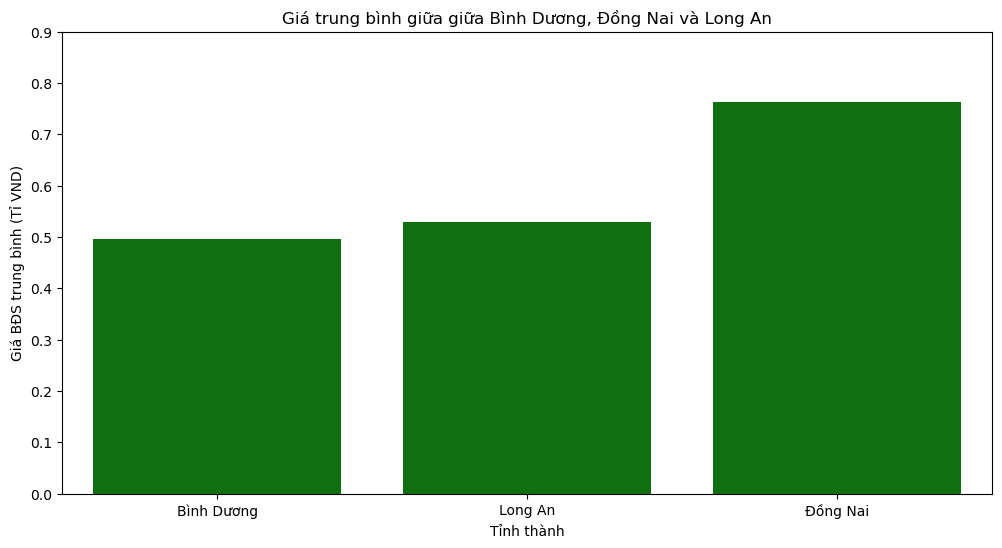

In [510]:
average_province = df_newzone.groupby('Province')['Price'].mean()

plt.figure(figsize=(12,6))
sns.barplot(x=average_province.index, y=average_province.values, color='Green')

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/(10*(10**9)):,.1f}' for tick in yticks])

plt.title('Giá trung bình giữa giữa Bình Dương, Đồng Nai và Long An')
plt.xlabel('Tỉnh thành')
plt.ylabel('Giá BĐS trung bình (Tỉ VND)')

;

In [511]:
# 2. Box Plot: Hiển thị phân phối giá ở các vùng khác nhau.

''

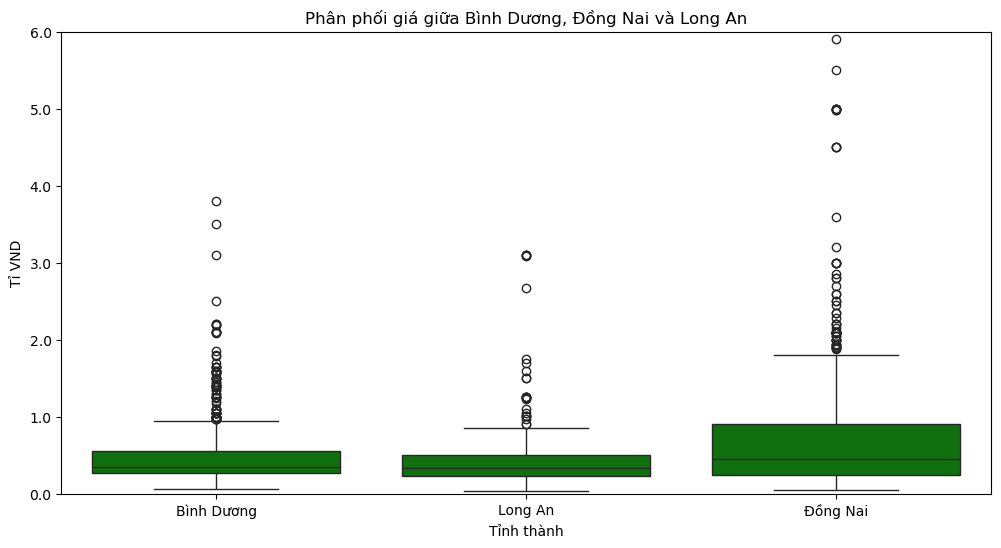

In [512]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Province', y='Price', data=df_newzone, color='Green')
plt.ylim(0, 60000000000)

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/(10*(10**9)):,.1f}' for tick in yticks])

plt.title('Phân phối giá giữa Bình Dương, Đồng Nai và Long An')
plt.xlabel('Tỉnh thành')
plt.ylabel('Tỉ VND')

;

In [513]:
#3. Violin Plot: Phân tích sự phân tán giá.

''

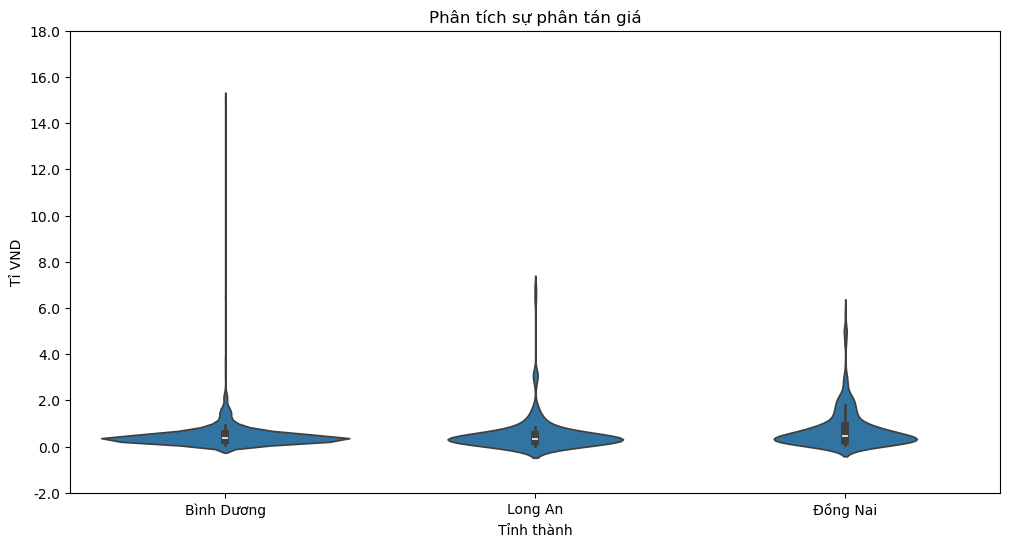

In [514]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='Province', y='Price', data=df_newzone)

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/(10*(10**9)):,.1f}' for tick in yticks])

plt.title('Phân tích sự phân tán giá')
plt.xlabel('Tỉnh thành')
plt.ylabel('Tỉ VND')
;


In [515]:
# 4.Scatter Plot: Quan hệ giữa giá và số phòng ngủ.

''

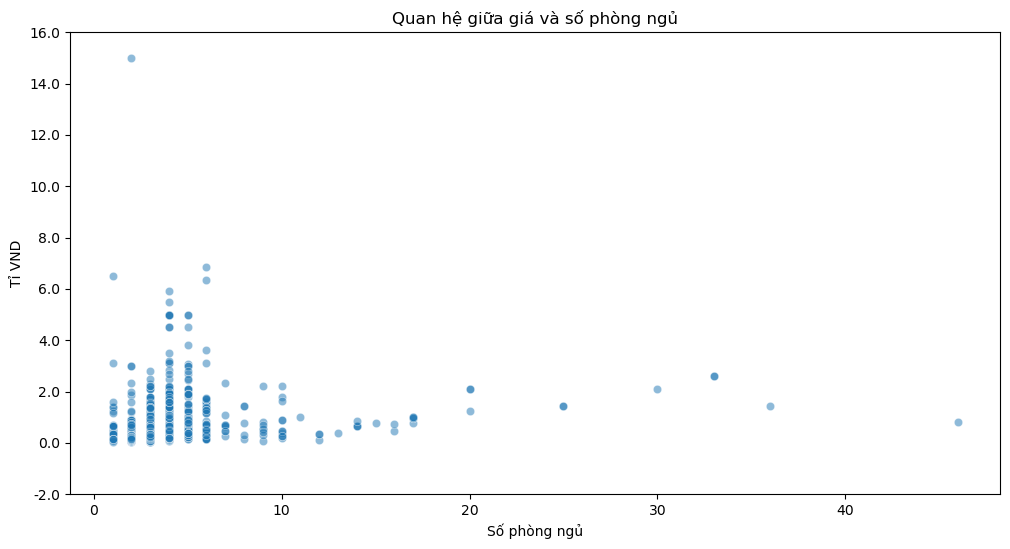

In [516]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='BedRoom', y='Price', data=df_newzone, alpha=0.5)

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/(10*(10**9)):,.1f}' for tick in yticks])

plt.title('Quan hệ giữa giá và số phòng ngủ')
plt.xlabel('Số phòng ngủ')
plt.ylabel('Tỉ VND')
;

In [517]:
# 6.Pie Chart: Phân bố số lượng bất động sản theo khu vực.

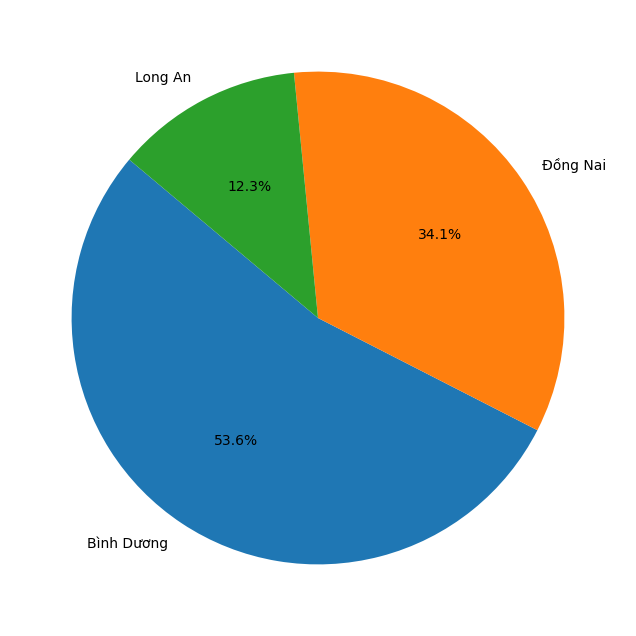

In [518]:
real_estate_counts = df_newzone['Province'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(real_estate_counts, labels=real_estate_counts.index, autopct='%1.1f%%', startangle=140);

In [519]:
# Histogram: Phân phối giá của bất động sản.

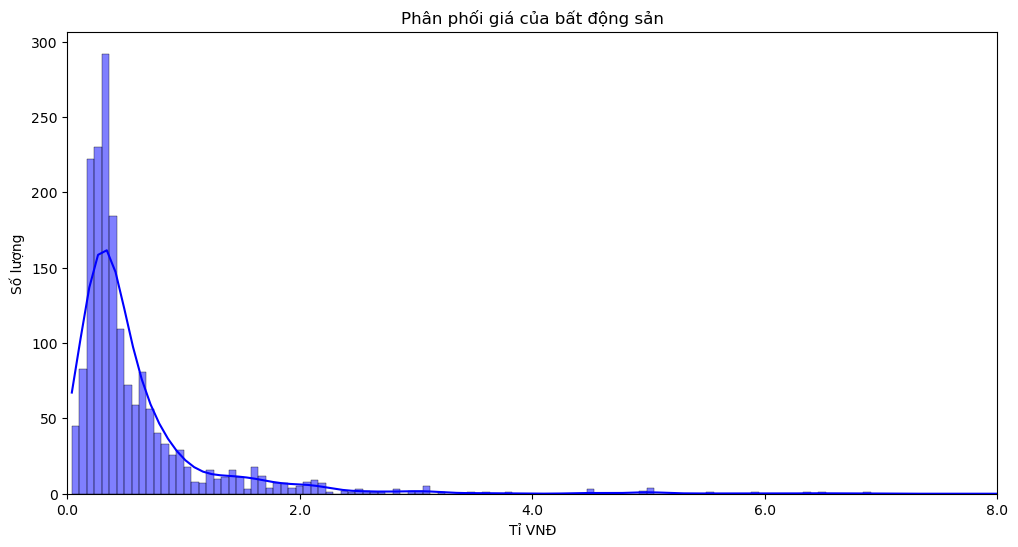

In [597]:
plt.figure(figsize=(12, 6))
sns.histplot(df_newzone['Price'], kde=True, color='blue')

xticks = plt.xticks()[0]
plt.xticks(xticks, labels=[f'{float(tick)/(10*(10**9)):,.1f}' for tick in xticks])
plt.xlim(0)
plt.xlim(0,80000000000)

plt.title('Phân phối giá của bất động sản')
plt.xlabel('Tỉ VNĐ')
plt.ylabel('Số lượng');

In [599]:
# Histogram: Phân phối giá của bất động sản.

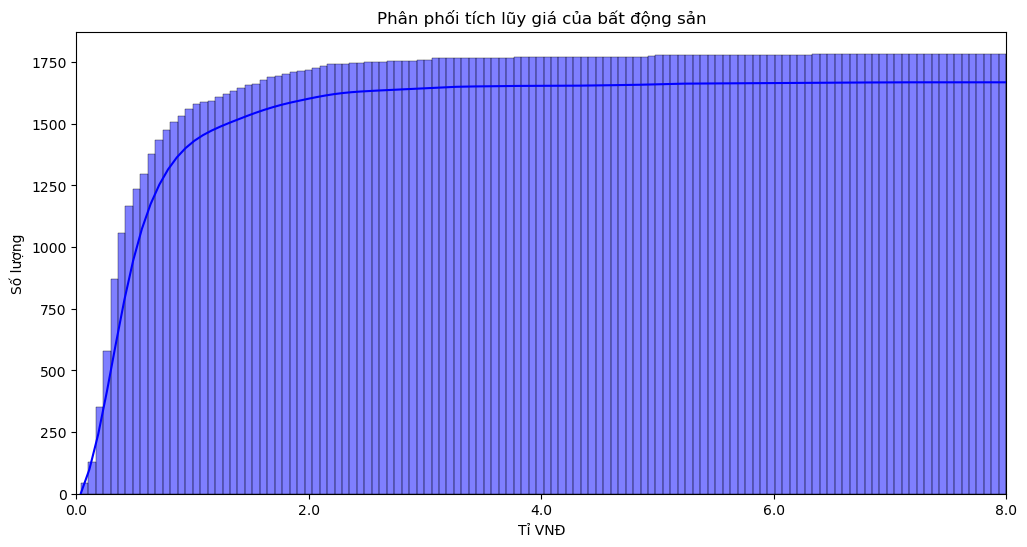

In [603]:
plt.figure(figsize=(12, 6))
sns.histplot(df_newzone['Price'], kde=True, color='blue', cumulative=True)

xticks = plt.xticks()[0]
plt.xticks(xticks, labels=[f'{float(tick)/(10*(10**9)):,.1f}' for tick in xticks])
plt.xlim(0)
plt.xlim(0,80000000000)

plt.title('Phân phối tích lũy giá của bất động sản')
plt.xlabel('Tỉ VNĐ')
plt.ylabel('Số lượng');

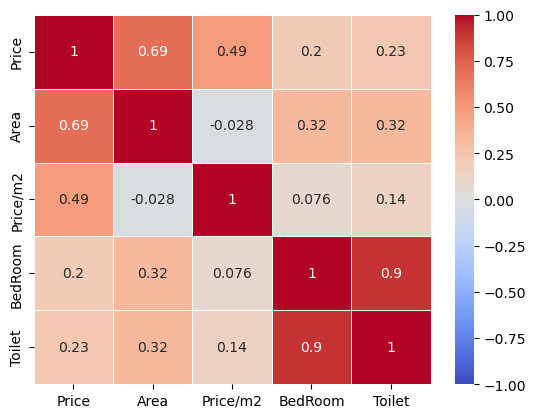

In [521]:
# Heatmap: Tương quan giữa giá và các yếu tố khác.
corr_matrix = df_newzone[['Price', 'Area', 'Price/m2', 'BedRoom', 'Toilet']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5);

In [522]:
# Pair Plot: Tương quan giữa các biến số khác nhau.

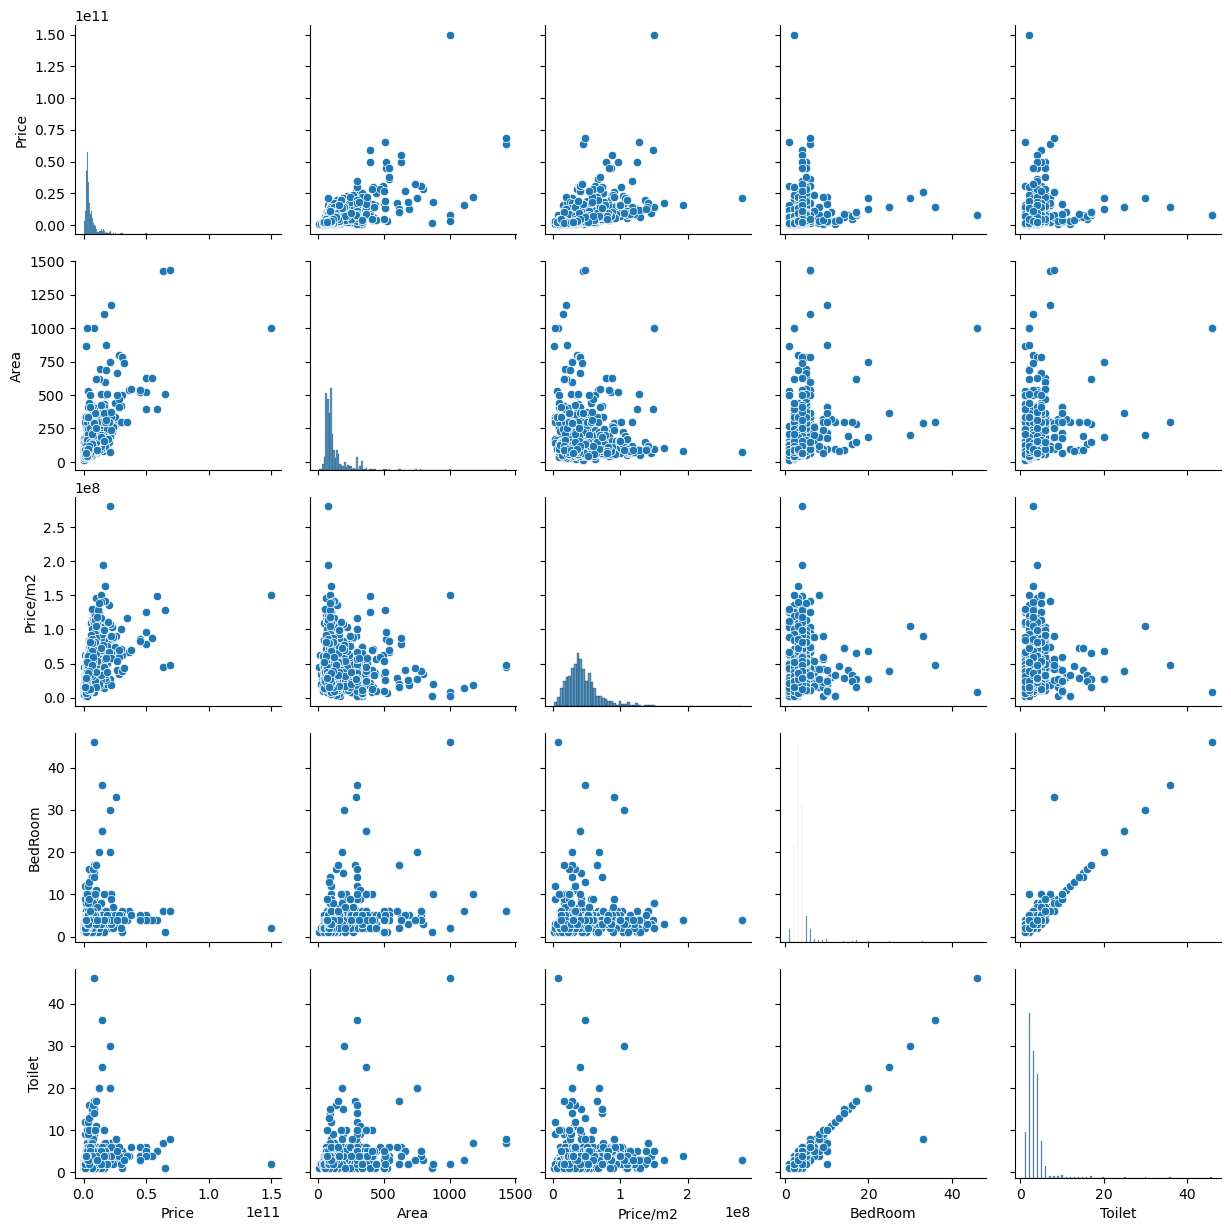

In [523]:
sns.pairplot(df_newzone[['Price', 'Area', 'Price/m2', 'BedRoom', 'Toilet']]);

In [524]:
# Density Plot

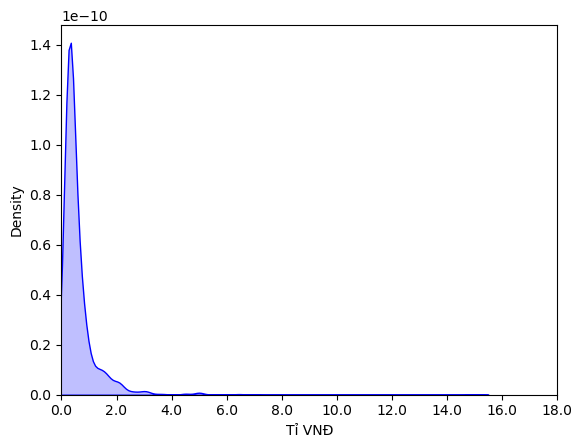

In [525]:
sns.kdeplot(df_newzone['Price'], color='blue', fill=True)

xticks = plt.xticks()[0]
plt.xticks(xticks, labels=[f'{float(tick)/(10*(10**9)):,.1f}' for tick in xticks])
plt.xlim(0)

plt.xlabel('Tỉ VNĐ');

In [526]:
# Area Plot: Hiển thị xu hướng giá.

''

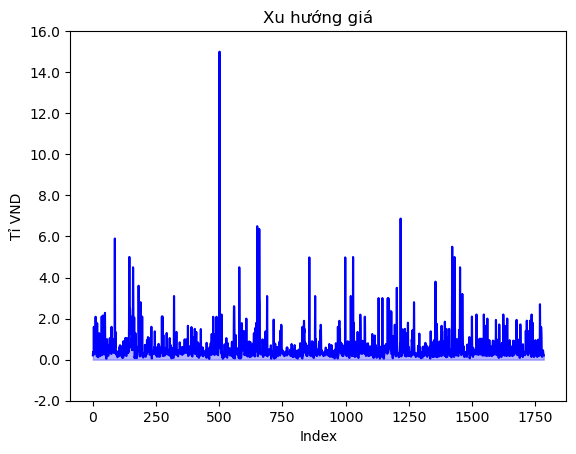

In [527]:
sns.lineplot(data=df_newzone['Price'], color='blue')
plt.fill_between(df_newzone.index, df_newzone['Price'], color='blue', alpha=0.3)

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/(10*(10**9)):,.1f}' for tick in yticks])

plt.title('Xu hướng giá')
plt.xlabel('Index')
plt.ylabel('Tỉ VND')
;

In [528]:
# Biểu đồ bong bóng của giá bất động sản theo diện tích

''

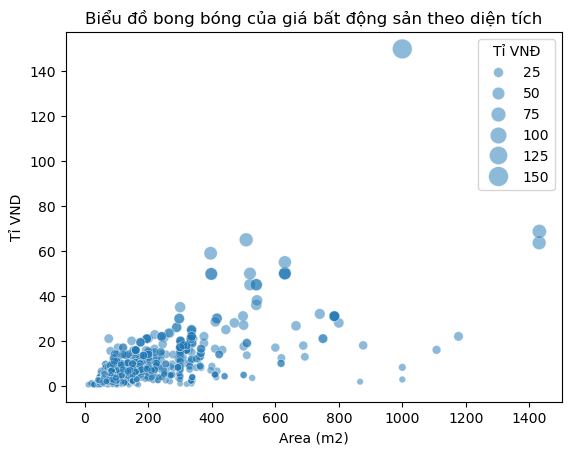

In [529]:
price_billion = df_newzone['Price'].apply(lambda x: x/(10**9))

sns.scatterplot(x=df_newzone.Area, y=price_billion, size=price_billion, sizes=(20, 200), alpha=0.5)

plt.title('Biểu đồ bong bóng của giá bất động sản theo diện tích')
plt.xlabel('Area (m2)')
plt.ylabel('Tỉ VND')

plt.legend(title='Tỉ VNĐ', fontsize='10')

;

# 6. Regression Analysis

In [531]:
# Huấn luyện mô hình
df_newzone['Province_encoded'] = LabelEncoder().fit_transform(df_newzone['Province'])
X = df_newzone[['Area', 'BedRoom', 'Toilet', 'Province_encoded']]
Y = df_newzone[['Price']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, Y_train)
price_predictions = model.predict(X_test)

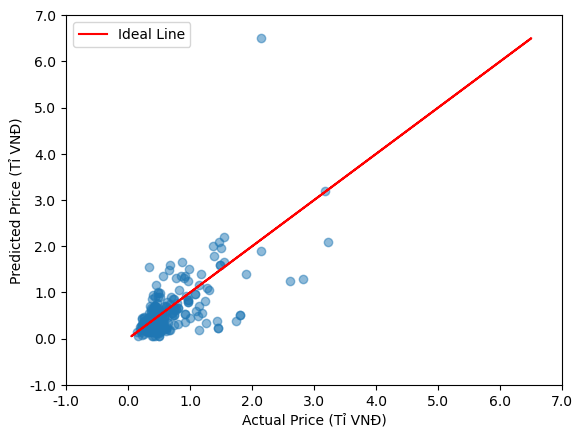

In [532]:
# Visualize khả năng dự đoán
plt.scatter(x=price_predictions, y=Y_test.values, alpha=0.5)
plt.plot(Y_test.values, Y_test.values, color='red', label='Ideal Line')

plt.ylabel('Predicted Price (Tỉ VNĐ)')
plt.xlabel('Actual Price (Tỉ VNĐ)')
plt.legend()

xticks = plt.xticks()[0]
plt.xticks(xticks, labels=[f'{float(tick)/(10*(10**9)):,.1f}' for tick in xticks])

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/(10*(10**9)):,.1f}' for tick in yticks]);

In [533]:
# Đánh giá hiệu suất model

In [534]:
mse = mean_squared_error(Y_test, price_predictions)
mae = mean_absolute_error(Y_test, price_predictions)
r2 = r2_score(Y_test, price_predictions)
intercept = model.intercept_  
coefficients = model.coef_   

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² score: {r2}")
print(f"Intercept (β0 - Hằng số): {intercept}")
print(f"Hệ số hồi quy (β1, β2, β3,...): {coefficients}")

Mean Squared Error (MSE): 1.6002120225946235e+19
Mean Absolute Error (MAE): 2266050196.360773
R² score: 0.3974440786173916
Intercept (β0 - Hằng số): [1.15583555e+08]
Hệ số hồi quy (β1, β2, β3,...): [[ 4.19250051e+07 -3.11722605e+08  2.97157605e+08  4.72651171e+08]]
